In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Please change this path to your own path for usage

In [4]:
# import all required dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report


# please change the os.walk(path) to your own path 
for dirpath, dirname, filename in os.walk('/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/Training'):
  print(dirpath)
  print(dirname)
  print(filename)

/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/Training
['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
['.DS_Store']
/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/Training/no_tumor
[]
['7.jpg', 'image(86).jpg', 'image(304).jpg', 'image(265).jpg', 'image(104).jpg', 'image(10).jpg', 'image(22).jpg', 'image (4).jpg', 'image(77).jpg', 'image(134).jpg', 'image(325).jpg', 'image(280).jpg', 'image(21).jpg', 'image(95).jpg', 'image(284).jpg', 'image (21).jpg', 'image(140).jpg', 'image(29).jpg', 'image(8).jpg', 'image(112).jpg', 'image(221).jpg', 'image(41).jpg', 'image (50).jpg', 'image(57).jpg', 'image (62).jpg', 'image(298).jpg', 'image(235).jpg', 'image (11).jpg', 'image(103).jpg', 'image(233).jpg', 'image(324).jpg', 'image(158).jpg', 'image(33).jpg', 'image(151).jpg', 'image(225).jpg', 'image(105).jpg', 'image(183).jpg', 'image (13).jpg', 'image(116).jpg', 'image(259).jpg', 'image(302).jpg', 'image(315).jpg', 'image(199).jpg', 'image(196).jpg', 'image(

In [ ]:
# get the total number of the training & testing dataset after downloaded from the Kaggle website
def count_files_in_folder(folder_path):
    # List all items in the folder
    all_items = os.listdir(folder_path)
    # Filter for files only
    files = [item for item in all_items if os.path.isfile(os.path.join(folder_path, item))]
    return len(files)

# change folder paths to your own path
folder_path1 = '/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/Training/glioma_tumor'
folder_path2 = '/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/Training/meningioma_tumor'
folder_path3 = '/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/Training/no_tumor'
folder_path4 = '/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/Training/pituitary_tumor'
folder_lst = [folder_path1, folder_path2, folder_path3, folder_path4]
for path in folder_lst:
  file_count = count_files_in_folder(path)
  print(f"Number of files: {file_count}")


Number of files: 826
Number of files: 822
Number of files: 395
Number of files: 827


## Data loading and preprocessing

In [ ]:
# loading all image data:
img_size = (224, 224)  # set images to this size globally
batch_size = 32  # set batch size globally
seed = 168  # Random seed for consistency and ensure reproducibility
validation_split = 0.2  # 20% of the data will be used for validation

training_data = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/Training',
    validation_split=validation_split,
    subset='training',
    labels='inferred',
    color_mode = 'grayscale', # using grayscale as all images in MRI which is black and white 
    image_size= img_size,
    batch_size= batch_size,
    shuffle = True,
    label_mode='categorical',
    seed = seed
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/Training',
    validation_split=validation_split,
    subset='validation',
    labels='inferred',
    color_mode = 'grayscale',
    image_size= img_size,
    batch_size= batch_size,
    shuffle = False,
    label_mode='categorical',
    seed = seed
)

testing_data = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/Testing',
    labels='inferred',
    color_mode = 'grayscale',
    image_size= img_size,
    batch_size= batch_size,
    shuffle = False,
    label_mode='categorical',
    seed = seed
)


Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.


In [ ]:
# check the class names
class_names = training_data.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [ ]:
# Checking the loaded data before resizing and scaling:
for images, labels in training_data.take(1):  # Take one batch of data from the tf.data.Data _mapData object
    print(images.shape)  # get the data shape after loaded
    print(images[0].shape)  # get the single image data's shape --> which is converted in tensors 
    print(labels.shape)  # Shape of the labels batch, 32 batch all with 4 classes

(32, 224, 224, 1)
(224, 224, 1)
(32, 4)


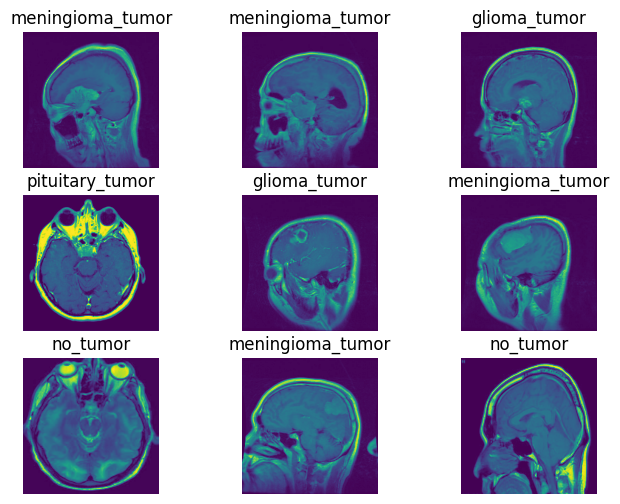

In [ ]:
# visualise first 9 images
plt.figure(figsize=(8,6))
for images, labels in training_data.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])
    plt.axis("off")
plt.show()

## Apply image data transformation before passing into model

In [ ]:
# Define a normalization layer, as the pixels range (1 to 255) on color scale, normalise it between (0 and 1)
normalisation_layer = tf.keras.layers.Rescaling(1./255)

# Add data augumentation layer to the training_dataset for increase diversity and prevent overfitting.
# because we can see the dataset is realatively small. so need to apply augumentation to increase training.
data_augumentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'), # can't vertically flip as pathology MRI contains anatomically significance position, vertical rotation would distort and lead to biases.
    tf.keras.layers.RandomRotation(0.1), # begin with small range rotation and zoom
    tf.keras.layers.RandomZoom(0.1)
    # No random contrast change as not suitable for the image
])

# Apply augumentation and rescale to the training_data first
training_data_augumented = training_data.map(lambda x, y: (data_augumentation_layer(x), y))
training_data_normalised = training_data_augumented.map(lambda x, y: (normalisation_layer(x), y))

# Apply normalization to val and testing data as well.
validation_data_normalised = validation_data.map(lambda x, y: (normalisation_layer(x), y))
testing_data_normalised = testing_data.map(lambda x, y: (normalisation_layer(x), y))

In [ ]:
# checking to see in what form the data has being transformed
for images, labels in training_data_normalised.take(1):
    normalised_image = images[0].numpy()  # Take the first image from the batch
print(normalised_image)

[[[0.01927318]
  [0.01254504]
  [0.00946778]
  ...
  [0.01177225]
  [0.01189463]
  [0.01312838]]

 [[0.02063178]
  [0.01450988]
  [0.01112485]
  ...
  [0.01187325]
  [0.01299178]
  [0.01270919]]

 [[0.01889278]
  [0.01432616]
  [0.01003027]
  ...
  [0.01094105]
  [0.01130759]
  [0.01434347]]

 ...

 [[0.23306751]
  [0.23228483]
  [0.26107562]
  ...
  [0.02933275]
  [0.03133793]
  [0.02731193]]

 [[0.23775771]
  [0.21503246]
  [0.23706175]
  ...
  [0.02452802]
  [0.02612936]
  [0.02700286]]

 [[0.24912381]
  [0.20894869]
  [0.21016297]
  ...
  [0.01894219]
  [0.01670063]
  [0.02553867]]]


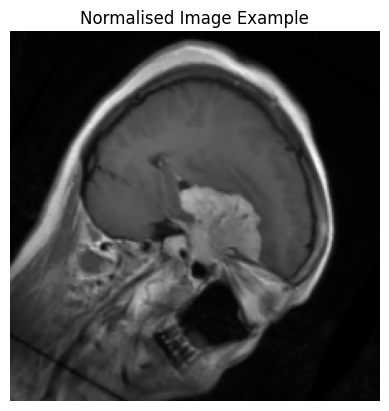

In [ ]:
# Plot the normalized image
plt.imshow(normalised_image.squeeze(), cmap='gray')  # .squeeze() removes extra dimensions
plt.title('Normalised Image Example')
plt.axis('off')
plt.show()

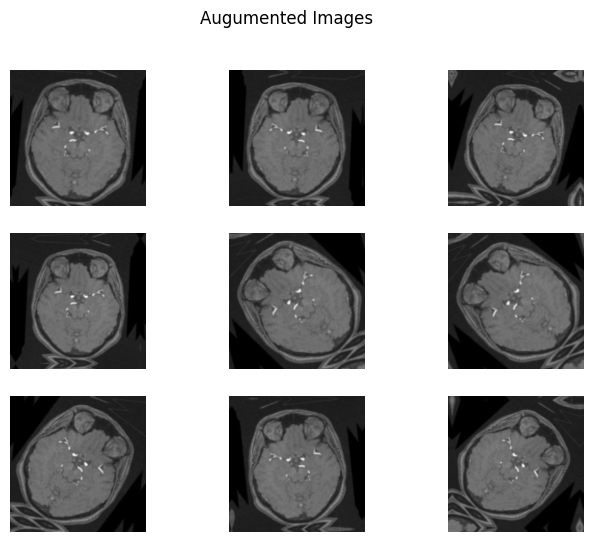

In [ ]:
# visualise data augumentaion:
plt.figure(figsize=(8,6))
for images, labels in training_data_normalised.take(1):
  sample_image = images[0]

for i in range(9):
  augumented_img = data_augumentation_layer(tf.expand_dims(sample_image, axis=0))
  ax = plt.subplot(3,3,i+1)
  plt.imshow(augumented_img[0].numpy().squeeze(), cmap='gray')
  plt.axis("off")
plt.suptitle("Augumented Images")
plt.show()

## Construct the CNN model from scratch

In [ ]:
# calling Sequential layer first
model = Sequential()

# Add the input layer explicitly
model.add(Input(shape=(224, 224, 1)))  # Grayscale images resized to 224x224X1 for unified input

# First Conv block
model.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Second Conv block
model.add(Conv2D(64, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Third Conv block
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Flatten and Connect Dense layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer for 4 classes
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,422,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,548,804 (24.98 MB)

 Trainable params: 6,548,804 (24.98 MB)

 Non-trainable params: 0 (0.00 B)

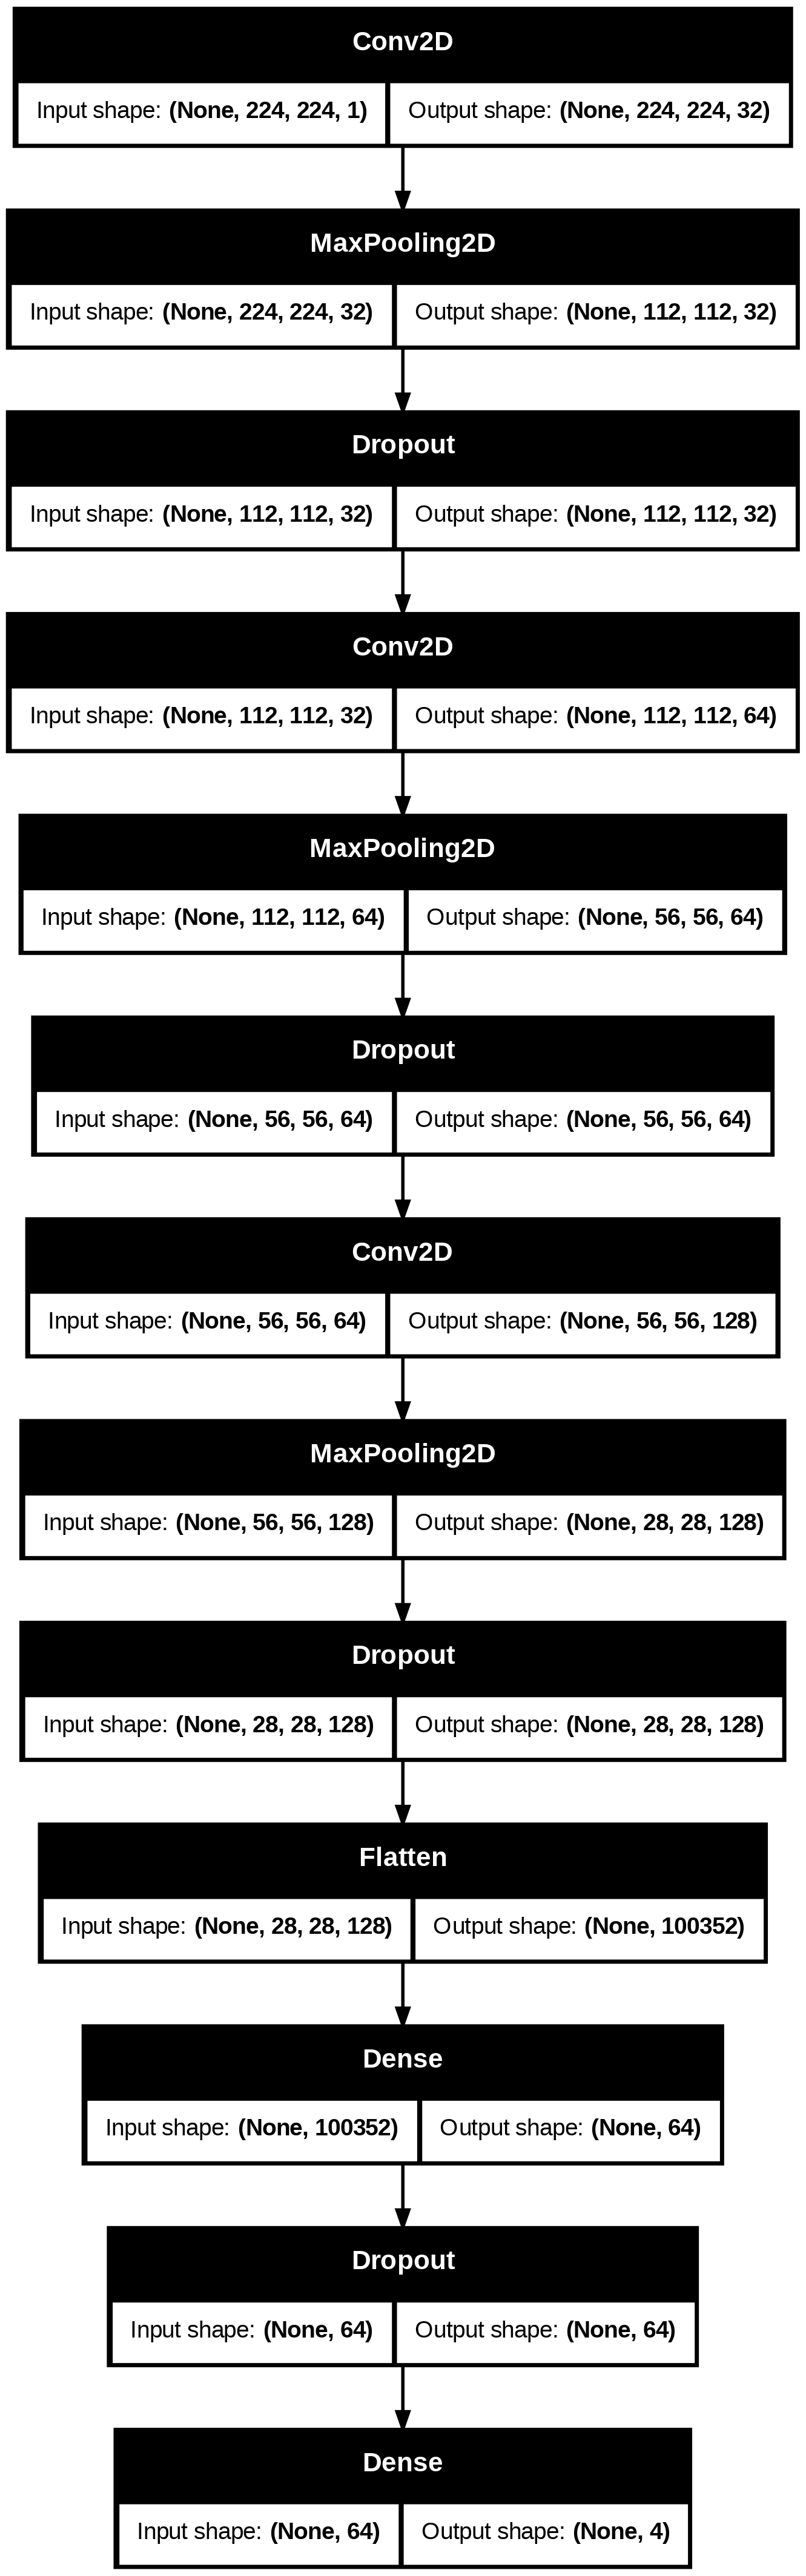

In [ ]:
# visualise the cnn model
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
# Implement earlystopping and callbacks to prevent overfitting and stop when the model stops improving
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=3, # Stop training if val_loss doesn't improve after 3 epochs
    restore_best_weights=True # Restore the best weights after stopping
)

In [ ]:
history_1 = model.fit(
    training_data_normalised,
    validation_data= validation_data_normalised,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.3917 - loss: 1.3605 - val_accuracy: 0.7631 - val_loss: 1.1269
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.4797 - loss: 1.1169 - val_accuracy: 0.5000 - val_loss: 1.2946
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.5188 - loss: 1.0308 - val_accuracy: 0.6760 - val_loss: 0.8579
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.5522 - loss: 0.9724 - val_accuracy: 0.8711 - val_loss: 0.7035
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.6219 - loss: 0.8831 - val_accuracy: 0.9216 - val_loss: 0.5116
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.6097 - loss: 0.8353 - val_accuracy: 0.8014 - val_loss: 0.7233
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.6188 - loss: 0.8380 - val_accuracy: 0.9303 - val_loss: 0.5756
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.6477 - loss: 0.7659 - val_accura

In [ ]:
# evaluate the model on test data
test_loss, test_accuracy = model.evaluate(testing_data_normalised)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.2119 - loss: 2.2275
Test Loss: 1.6764836311340332
Test Accuracy: 0.29949238896369934


#### we can see after the first training, model testing accuracy is terrible.

In [ ]:
# convert training history to data frame
h1_df = pd.DataFrame(history_1.history)
h1_df

,accuracy,loss,val_accuracy,val_loss
0,0.418990,1.271260,0.763066,1.126899
1,0.495645,1.085210,0.500000,1.294639
2,0.550958,1.011055,0.675958,0.857868
3,0.574042,0.961086,0.871080,0.703542
4,0.621080,0.887652,0.921603,0.511609
5,0.622387,0.855119,0.801394,0.723306
6,0.634582,0.829506,0.930314,0.575564
7,0.659408,0.752715,0.869338,0.533956


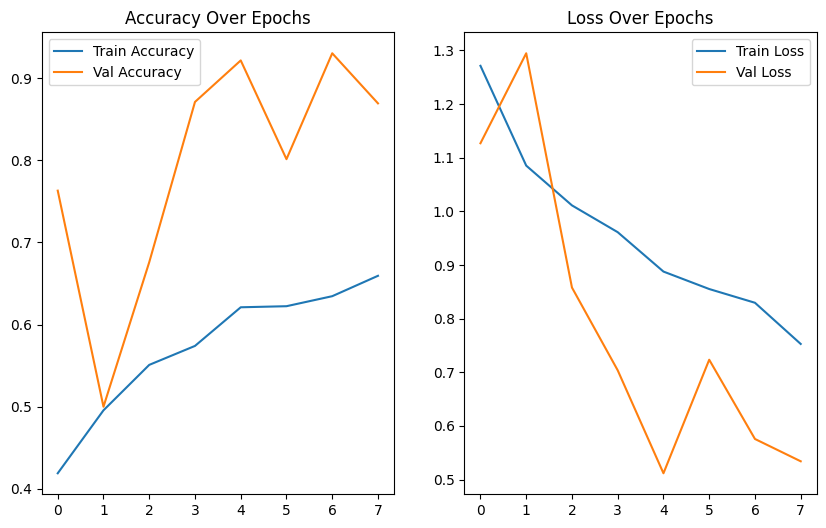

In [ ]:
# plot the accuracy and loss:
fig, ax = plt.subplots(1,2, figsize=(10, 6))
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

In [ ]:
# Save the h1 record to csv
h1_df.to_csv('/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/h1_df.csv', index=False, header = True)

In [ ]:
# save the entire model as .h5 file
model.save('/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/model_1.h5')

## Model optimisations

### Optimisation Method 1: Adding more epochs and adjust the data augumentation:

* set the new epochs to 40
* Apply more angle on rotating and zooming

In [ ]:
# load model
loaded_model_1 = load_model('/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/model_1.h5')

# check the model summary to ensure loaded correctly
loaded_model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,422,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,548,806 (24.98 MB)

 Trainable params: 6,548,804 (24.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
# Reload the dataset:
img_size = (224, 224)  # set images to this size globally
batch_size = 32  # set batch size globally
seed = 168  # Random seed for consistency and ensure reproducibility
validation_split = 0.2  # 20% of the data will be used for validation

training_data_for_optimise1 = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/Training',
    validation_split=validation_split,
    subset='training',
    labels='inferred',
    color_mode = 'grayscale',
    image_size= img_size,
    batch_size= batch_size,
    shuffle = True,
    label_mode='categorical',
    seed = seed
)

validation_data_for_optimise1 = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/Training',
    validation_split=validation_split,
    subset='validation',
    labels='inferred',
    color_mode = 'grayscale',
    image_size= img_size,
    batch_size= batch_size,
    shuffle = False,
    label_mode='categorical',
    seed = seed
)

testing_data_for_optimise1 = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/Testing',
    labels='inferred',
    color_mode = 'grayscale',
    image_size= img_size,
    batch_size= batch_size,
    shuffle = False,
    label_mode='categorical',
    seed = seed
)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.


In [ ]:
# normalization layer as usual
normalisation_layer = tf.keras.layers.Rescaling(1./255)

# Before apply new epochs, I decide to improve the data augumentation layer to add more randomness
new_aug_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'), # did not apply vertical as MRI scan not suitable for vertical flip
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.CenterCrop(height=224, width=224) # add croping to trim some edge and centralise image
])

# Apply data augmentation and normalization to the training dataset
training_data_augumented_2 = training_data_for_optimise1.map(lambda x, y:(new_aug_layer(x), y))

# apply normalisation:
training_data_2_normalised = training_data_augumented_2.map(lambda x, y: (normalisation_layer(x), y))


# Apply normalization to validation and testing datasets (without augmentation)
validation_data_2 = validation_data_for_optimise1.map(
    lambda x, y: (normalisation_layer(x), y)
)

testing_data_2 = testing_data_for_optimise1.map(
    lambda x, y: (normalisation_layer(x), y)
)


Image after augmentation and normalization (numpy array):
[[[0.33309516]
  [0.33799323]
  [0.38506466]
  ...
  [0.10961366]
  [0.11167063]
  [0.12201362]]

 [[0.3343477 ]
  [0.32080588]
  [0.32658088]
  ...
  [0.11237793]
  [0.10761242]
  [0.1090316 ]]

 [[0.30906063]
  [0.32289365]
  [0.32664007]
  ...
  [0.11662421]
  [0.11152457]
  [0.10765811]]

 ...

 [[0.39040467]
  [0.45427662]
  [0.50345373]
  ...
  [0.49541593]
  [0.4910809 ]
  [0.44561285]]

 [[0.33563164]
  [0.41380242]
  [0.5006911 ]
  ...
  [0.47281855]
  [0.5025287 ]
  [0.5072958 ]]

 [[0.3091351 ]
  [0.36278605]
  [0.46279523]
  ...
  [0.41805932]
  [0.45012546]
  [0.46994132]]]


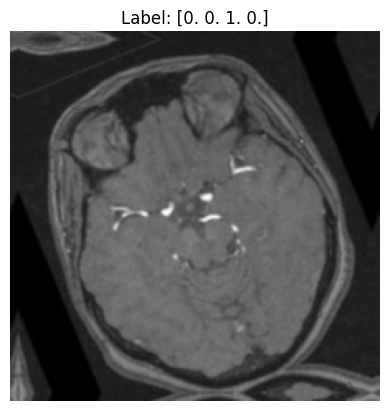

In [ ]:
# checking after resize and aug:
for images, labels in training_data_2_normalised.take(1):  # Take a single batch
    # Since it's a batch, extract the first image and its label
    first_image = images[0]
    first_label = labels[0]

    # Print the image array values after augmentation and normalization
    print("Image after augmentation and normalization (numpy array):")
    print(first_image.numpy())

    # Plot the image
    plt.imshow(first_image.numpy().squeeze(), cmap='gray')  # Using grayscale since it's 1 channel
    plt.title(f'Label: {first_label.numpy()}')
    plt.axis('off')  # Remove axis for a cleaner image display
    plt.show()

    break  # Exit the loop after the first batch

In [ ]:
# Recompile the model for optimise training again:
loaded_model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
loaded_model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,422,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,548,804 (24.98 MB)

 Trainable params: 6,548,804 (24.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# start the optimisation
history_2 = loaded_model_1.fit(
    training_data_2_normalised,
    validation_data = validation_data_2,
    epochs=40
) # remove early_stop here enable full 40 epochs

Epoch 1/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 182ms/step - accuracy: 0.5609 - loss: 0.9862 - val_accuracy: 0.8206 - val_loss: 0.7269
Epoch 2/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.6129 - loss: 0.9116 - val_accuracy: 0.7822 - val_loss: 0.7230
Epoch 3/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.6015 - loss: 0.8762 - val_accuracy: 0.7787 - val_loss: 0.8771
Epoch 4/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.6469 - loss: 0.8501 - val_accuracy: 0.8275 - val_loss: 0.6638
Epoch 5/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.6520 - loss: 0.8042 - val_accuracy: 0.9007 - val_loss: 0.6319
Epoch 6/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.6375 - loss: 0.8063 - val_accuracy: 0.8101 - val_loss: 0.6686
Epoch 7/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.6499 - loss: 0.8069 - val_accuracy: 0.8763 - val_loss: 0.6929
Epoch 8/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.6529 - loss: 0.7878 - val_accu

In [ ]:
# evaluate the loss and accuracy for the optimised model:
test_loss_2, test_accuracy_2 = loaded_model_1.evaluate(testing_data_2)
print(f"Test Loss: {test_loss_2}")
print(f"Test Accuracy: {test_accuracy_2}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.2427 - loss: 5.8653
Test Loss: 3.216900110244751
Test Accuracy: 0.39593908190727234


#### we can see slight improvement, however still low. This indicates need other methods to optimise further

In [ ]:
# save the loaded_model_2 history as dataframe
h2_df = pd.DataFrame(history_2.history)
h2_df

,accuracy,loss,val_accuracy,val_loss
0,0.581882,0.971513,0.820557,0.726939
1,0.612369,0.913606,0.782230,0.723003
2,0.607143,0.882203,0.778746,0.877120
3,0.642857,0.865400,0.827526,0.663795
4,0.639373,0.838971,0.900697,0.631941
5,0.639373,0.824149,0.810105,0.668613
6,0.647213,0.824423,0.876307,0.692912
7,0.661150,0.793094,0.904181,0.507673
8,0.655923,0.782849,0.904181,0.410752
9,0.672909,0.775560,0.909408,0.469765


In [ ]:
# save the h2_df as csv file:
h2_df.to_csv('/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/opt1_df.csv', index=False, header = True)

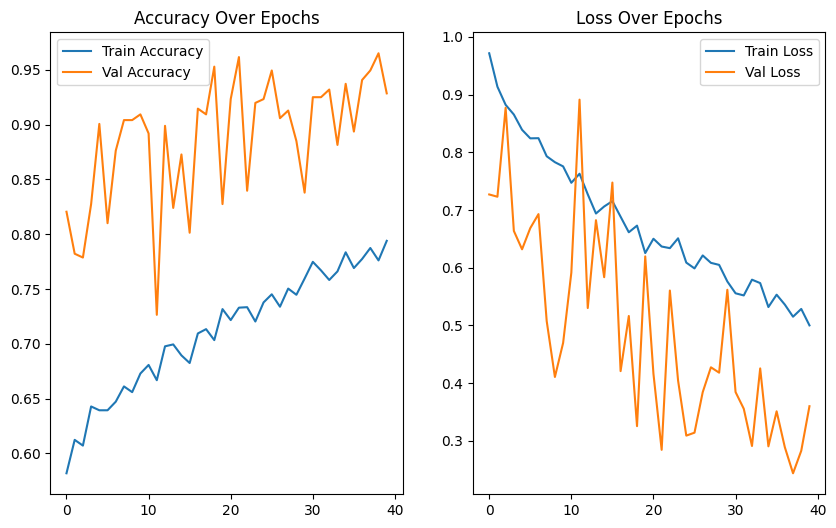

In [ ]:
# plot the new accuracy and loss :
fig, ax = plt.subplots(1,2, figsize=(10, 6))
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

In [ ]:
# Save the loaded_model as model_2.h5
loaded_model_1.save('/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/model_2.h5')

### Optimisation method 2: Adjust the learning rate, implement model checkpoint, and use ReduceLROnPlateau

* Lower the learning rate will take smaller step each time to see if better result can be achived

* ModelCheckPoint: This callbacks saves the best-performed model based on monitored metric (val_loss/val_accuracy)

* ReduceLROnPlateau: This callback reduce learning_rate by monitor changes in val_accuracy metric when model stops improving, till it reach the boarder learning rate.

In [8]:
# Hey! before start, reloaded the data first and apply the data preprocessing (nom/aug/rescale).
# Reload the dataset for optimisation round 2:
img_size = (224, 224)
batch_size = 32
seed = 168  # same seed for consistency
validation_split = 0.2  # same validation split

training_data_for_optimise2 = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/Training',
    validation_split=validation_split,
    subset='training',
    labels='inferred',
    color_mode = 'grayscale',
    image_size= img_size,
    batch_size= batch_size,
    shuffle = True,
    label_mode='categorical',
    seed = seed
)

validation_data_for_optimise2 = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/Training',
    validation_split=validation_split,
    subset='validation',
    labels='inferred',
    color_mode = 'grayscale',
    image_size= img_size,
    batch_size= batch_size,
    shuffle = False,
    label_mode='categorical',
    seed = seed
)

testing_data_for_optimise2 = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/Testing',
    labels='inferred',
    color_mode = 'grayscale',
    image_size= img_size,
    batch_size= batch_size,
    shuffle = False,
    label_mode='categorical',
    seed = seed
)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.


In [10]:
# Apply the same data preprocessing as before, nothing will be changed:
normalisation_layer = tf.keras.layers.Rescaling(1./255)

aug_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.CenterCrop(height=224, width=224)
])

# Apply data augmentation and normalization to the training dataset
training_data_augumented_3 = training_data_for_optimise2.map(lambda x, y:(aug_layer(x), y))
training_data_normalised_3 = training_data_augumented_3.map(lambda x, y: (normalisation_layer(x), y))

# Apply normalization to validation and testing datasets (without augmentation)
validation_data_3 = validation_data_for_optimise2.map(
    lambda x, y: (normalisation_layer(x), y)
)
testing_data_3 = testing_data_for_optimise2.map(
    lambda x, y: (normalisation_layer(x), y)
)


Image after augmentation and normalization (numpy array):
[[[0.01212881]
  [0.01228887]
  [0.01191249]
  ...
  [0.00784314]
  [0.00784314]
  [0.00784314]]

 [[0.01206972]
  [0.0122038 ]
  [0.01188851]
  ...
  [0.00784314]
  [0.00784314]
  [0.00784314]]

 [[0.01220867]
  [0.01240384]
  [0.01194491]
  ...
  [0.00784314]
  [0.00784314]
  [0.00784314]]

 ...

 [[0.01193844]
  [0.01176471]
  [0.01217322]
  ...
  [0.01327011]
  [0.01526684]
  [0.01441766]]

 [[0.01187422]
  [0.01176471]
  [0.01202222]
  ...
  [0.01148865]
  [0.01188157]
  [0.01171447]]

 [[0.01190153]
  [0.01176471]
  [0.01208644]
  ...
  [0.01224628]
  [0.01332127]
  [0.0128641 ]]]


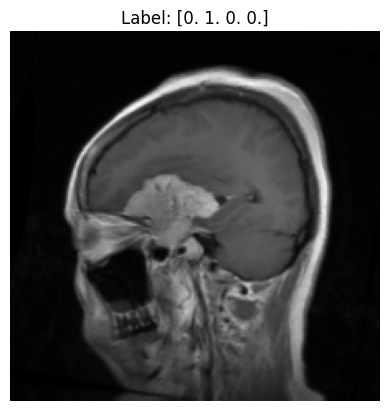

In [12]:
# Checking as usual:
for images, labels in training_data_normalised_3.take(1):
    first_image = images[0]
    first_label = labels[0]
    print("Image after augmentation and normalization (numpy array):")
    print(first_image.numpy())
    plt.imshow(first_image.numpy().squeeze(), cmap='gray')
    plt.title(f'Label: {first_label.numpy()}')
    plt.axis('off')
    plt.show()
    break

In [13]:
# reload the saved model_2 for this optimisation
loaded_model_2 = load_model('/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/model_2.h5')

loaded_model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,422,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,548,806 (24.98 MB)

 Trainable params: 6,548,804 (24.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [15]:
# set the new learning rate
new_learning_rate = 0.0005

# recompile the loaded_model_2 with a new learning rate
loaded_model_2.compile(
    optimizer = Adam(learning_rate = new_learning_rate),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
) # This round also temporarily remove the early_stop

In [19]:
# let's first try focus on the 'val_accuracy' in this round first for using both checkpoint and reduce_lr
# as it's essential for keeping constant during improvement. In the next round we will focus on 'val_loss'
checkpoint1 = tf.keras.callbacks.ModelCheckpoint(
    filepath = '/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/bestCP_loadedModel2_valAccuracy.weights.h5',
    monitor='val_accuracy',
    save_best_only=True, # only save the best performing model
    mode='max', # For val_acc, this should be max.
    verbose=1,
    save_weights_only=True
)

reduce_lr1 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    patience=3,
    min_lr= 1e-6, # this allow lr to reduce further
    mode = 'auto',
    verbose=1
)

csv_logger1= tf.keras.callbacks.CSVLogger(
    filename='/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/training_log_loadedModel2_valAccuracy.csv',
    separator=',',
    append=True
)

In [20]:
history_3 = loaded_model_2.fit(
    training_data_normalised_3,
    validation_data= validation_data_3,
    epochs=20,
    callbacks=[checkpoint1, reduce_lr1, csv_logger1]
)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7879 - loss: 0.4900
Epoch 1: val_accuracy improved from -inf to 0.92160, saving model to /content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/bestCP_loadedModel2_valAccuracy.weights.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.7881 - loss: 0.4900 - val_accuracy: 0.9216 - val_loss: 0.3153 - learning_rate: 5.0000e-04
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8210 - loss: 0.4583
Epoch 2: val_accuracy improved from 0.92160 to 0.92683, saving model to /content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/bestCP_loadedModel2_valAccuracy.weights.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.8209 - loss: 0.4585 - val_accuracy: 0.9268 - val_loss: 0.3222 - learning_rate: 5.0000e-04
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7983 - loss: 0.4655
Epoch 3: val_accuracy improved from 0.92683 to 0.95819, saving model to /content/drive/MyDrive/Colab_Notebooks/Brain_T

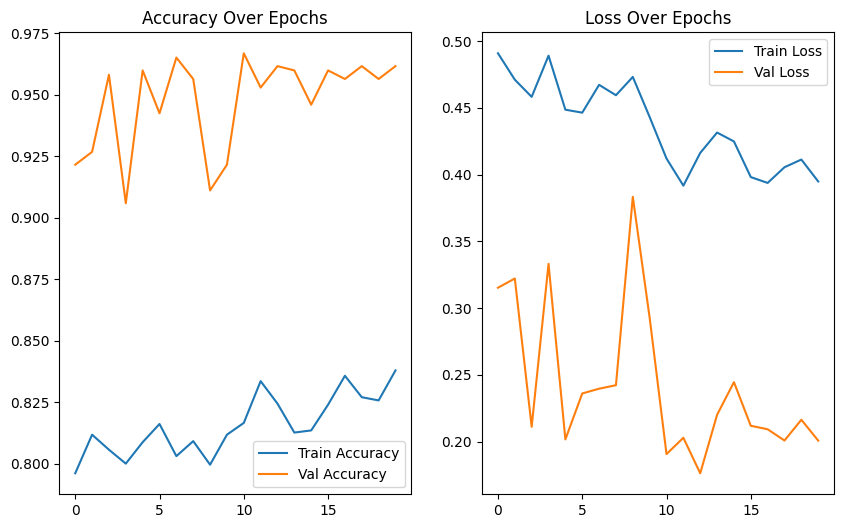

In [21]:
# plot the new accuracy and loss :
fig, ax = plt.subplots(1,2, figsize=(10, 6))
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_3.history['accuracy'], label='Train Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_3.history['loss'], label='Train Loss')
plt.plot(history_3.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

In [23]:
# evaluate the newly optimised model:
test_loss_3, test_accuracy_3 = loaded_model_2.evaluate(testing_data_3)
print(f"Test Loss: {test_loss_3}")
print(f"Test Accuracy: {test_accuracy_3}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.3028 - loss: 7.4931
Test Loss: 3.878608226776123
Test Accuracy: 0.4593908488750458


#### we can see some further improvement, but not enough

In [27]:
# generate confusion matrix and classification report
y_true = []
y_pred = []
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

for images, labels in testing_data_3:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(loaded_model_2.predict(images), axis=1))

# get the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", class_report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Confusion Matrix:
 [[ 15   9  69   7]
 [  1  37  74   3]
 [  0   1 104   0]
 [  0  16  33  25]]
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.94      0.15      0.26       100
meningioma_tumor       0.59      0.32      0.42       115
        no_tumor       0.37      0.99      0.54       105
 pituitary_tumor       0.71      0.34      0.46        74

        accuracy                           0.46       394
       macro avg       0.65      0.4

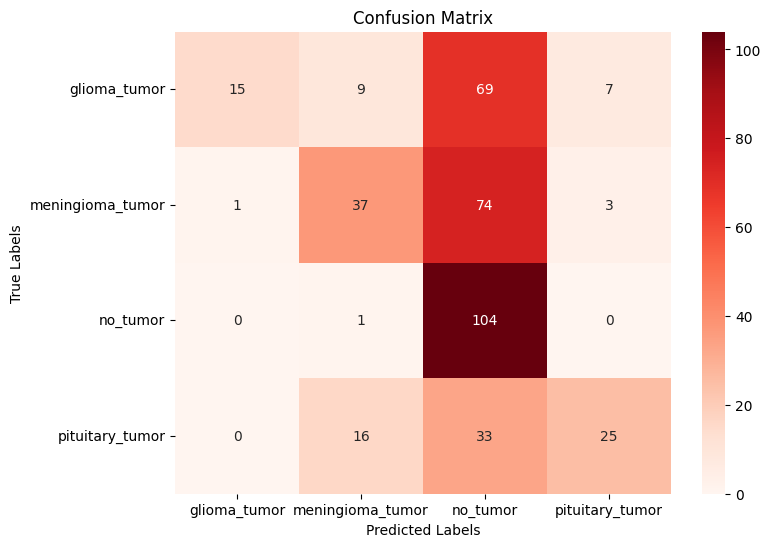

In [30]:
# plot the confusion matrix:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

In [32]:
# save the current model:
loaded_model_2.save('/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/model_3_valAccuracy.h5')

In [36]:
# Now let's try focus on 'val_loss' this time, rest remains the same, still 20 epochs
valLoss_model_optimise = load_model('/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/model_3_valAccuracy.h5')
valLoss_model_optimise.summary() # successfully loaded

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,422,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,548,806 (24.98 MB)

 Trainable params: 6,548,804 (24.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [37]:
# use load_weight to load the besrCP_loadedModel2_valAccuracy's weight into valLoss_model_optimise
valLoss_model_optimise.load_weights('/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/bestCP_loadedModel2_valAccuracy.weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [42]:
# Check the weights of a specific layer before and after loading weights
layer_names = ['conv2d', 'max_pooling2d', 'dropout', 'conv2d_1', 'max_pooling2d_1', 'dropout_1', 'conv2d_2', 'max_pooling2d_2', 'dropout_2', 'flatten', 'dense', 'dropout_3', 'dense_1']  # Example: Choose a layer from the list in the error message

# Iterate through each layer name and compare weights
for layer_name in layer_names:
    original_weights = loaded_model_2.get_layer(layer_name).get_weights()
    loaded_weights = valLoss_model_optimise.get_layer(layer_name).get_weights()

    # Compare weights for the current layer
    for orig, loaded in zip(original_weights, loaded_weights):
        print(f"Layer: {layer_name}, Weights match: {np.allclose(orig, loaded)}")  # Should print 'False' if weights were successfully updated

Layer: conv2d, Weights match: False
Layer: conv2d, Weights match: False
Layer: conv2d_1, Weights match: False
Layer: conv2d_1, Weights match: False
Layer: conv2d_2, Weights match: False
Layer: conv2d_2, Weights match: False
Layer: dense, Weights match: False
Layer: dense, Weights match: False
Layer: dense_1, Weights match: False
Layer: dense_1, Weights match: False


In [43]:
# recompile the model for this optimisation:
learning_rate = 0.0005

valLoss_model_optimise.compile(
    optimizer = Adam(learning_rate = learning_rate),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
) # This round also temporarily remove the early_stop

In [44]:
# set the 'val_loss' in checkpoint and reduceLROnPlateau
checkpoint2 = tf.keras.callbacks.ModelCheckpoint(
    filepath = '/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/bestCP_loadedModel2_valLoss.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min', # for val_loss, it should be minimal
    verbose=1,
    save_weights_only=True
)

reduce_lr2 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr= 1e-6,
    mode = 'auto',
    verbose=1
)

csv_logger2 = tf.keras.callbacks.CSVLogger(
    filename='/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/training_log_loadedModel2_valLoss.csv',
    separator=',',
    append=True
)

Image after augmentation and normalization (numpy array):
[[[0.42770967]
  [0.24839738]
  [0.08300604]
  ...
  [0.1374728 ]
  [0.1458367 ]
  [0.1632115 ]]

 [[0.38945773]
  [0.2110418 ]
  [0.05659653]
  ...
  [0.03335463]
  [0.04090067]
  [0.04796364]]

 [[0.3690123 ]
  [0.15210031]
  [0.04866698]
  ...
  [0.01265311]
  [0.01348113]
  [0.01414912]]

 ...

 [[0.23309572]
  [0.22085968]
  [0.21197276]
  ...
  [0.02102112]
  [0.02579653]
  [0.02624241]]

 [[0.24548855]
  [0.23669806]
  [0.23566835]
  ...
  [0.01992254]
  [0.02009028]
  [0.02598151]]

 [[0.250777  ]
  [0.2471491 ]
  [0.24933118]
  ...
  [0.01989746]
  [0.01987921]
  [0.03615928]]]


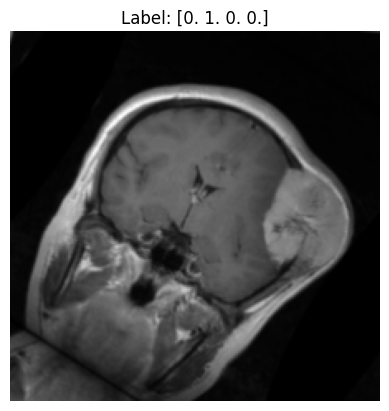

In [48]:
# before start, recheck the training data again:
for images, labels in training_data_normalised_3.take(1):
    first_image = images[0]
    first_label = labels[0]
    print("Image after augmentation and normalization (numpy array):")
    print(first_image.numpy())
    plt.imshow(first_image.numpy().squeeze(), cmap='gray')
    plt.title(f'Label: {first_label.numpy()}')
    plt.axis('off')
    plt.show()
    break

In [50]:
# start the val_loss optimise round
history_4 = valLoss_model_optimise.fit(
    training_data_normalised_3,
    validation_data= validation_data_3,
    epochs=20,
    callbacks=[checkpoint2, reduce_lr2, csv_logger2]
)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8290 - loss: 0.4203
Epoch 1: val_loss improved from inf to 0.31612, saving model to /content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/bestCP_loadedModel2_valLoss.weights.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 184ms/step - accuracy: 0.8288 - loss: 0.4206 - val_accuracy: 0.9373 - val_loss: 0.3161 - learning_rate: 5.0000e-04
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8206 - loss: 0.4362
Epoch 2: val_loss improved from 0.31612 to 0.21212, saving model to /content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/bestCP_loadedModel2_valLoss.weights.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.8206 - loss: 0.4363 - val_accuracy: 0.9721 - val_loss: 0.2121 - learning_rate: 5.0000e-04
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8269 - loss: 0.4248
Epoch 3: val_loss did not improve from 0.21212
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.8268 - loss: 0.4250 - val_a

In [52]:
# re-evaluate the model performance
test_loss_4, test_accuracy_4 = valLoss_model_optimise.evaluate(testing_data_3)
print(f"Test Loss: {test_loss_4}")
print(f"Test Accuracy: {test_accuracy_4}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3170 - loss: 7.2468
Test Loss: 3.7449140548706055
Test Accuracy: 0.46446701884269714


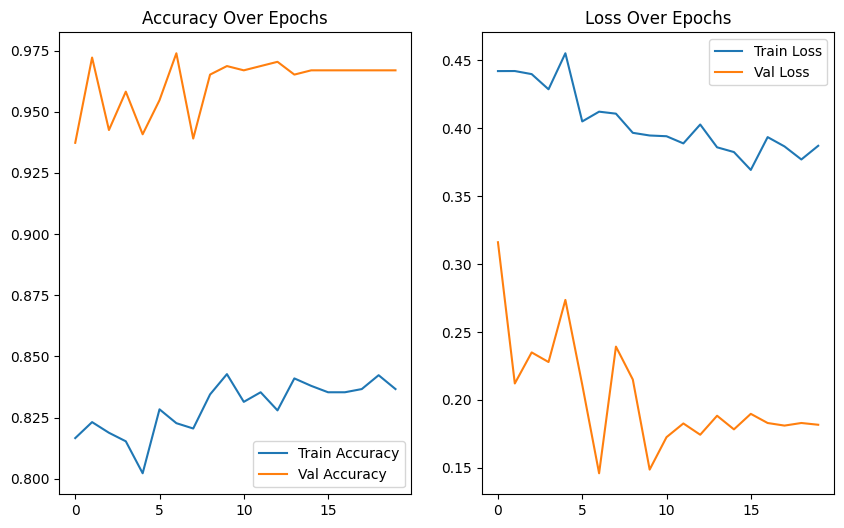

In [53]:
# plot the new accuracy and loss :
fig, ax = plt.subplots(1,2, figsize=(10, 6))
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_4.history['accuracy'], label='Train Accuracy')
plt.plot(history_4.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_4.history['loss'], label='Train Loss')
plt.plot(history_4.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

In [54]:
y_true2= []
y_pred2 = []
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

for images, labels in testing_data_3:
    y_true2.extend(np.argmax(labels.numpy(), axis=1))
    y_pred2.extend(np.argmax(valLoss_model_optimise.predict(images), axis=1))

# get the confusion matrix
cm2 = confusion_matrix(y_true2, y_pred2)
print("Confusion Matrix:\n", cm2)

# Classification Report
class_report2 = classification_report(y_true2, y_pred2, target_names=class_names)
print("Classification Report:\n", class_report2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
Confusion Matrix:
 [[ 15  14  66   5]
 [  2  43  66   4]
 [  0   1 104   0]
 [  0  21  32  21]]
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.88      0.15      0.26       100
meningioma_tumor       0.54      0.37      0.44       115
        no_tumor       0.39      0.99      0.56       105
 pituitary_tumor       0.70      0.28      0.40        74

        accuracy                           0.46       394
       macro avg       0.63      0

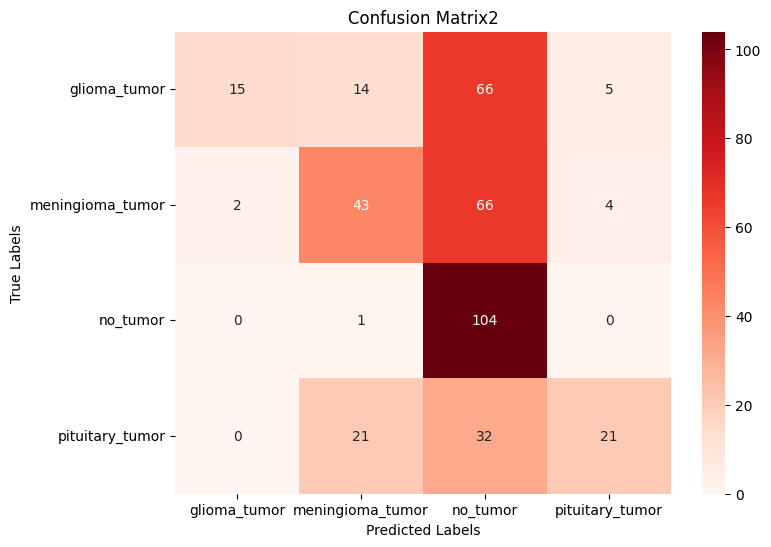

In [55]:
# plot the confusion matrix again:
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix2')
plt.show()

In [56]:
# save the model
valLoss_model_optimise.save('/content/drive/MyDrive/Colab_Notebooks/Brain_Tumor_MRI/model_4_valLoss.h5')